# Deep Learning

* This week, we'll learn about neural nets and build a model for classifying images of clothes
* We will use Tensorflow

## Data: Fashion Classification

* https://www.kaggle.com/datasets/zalando-research/fashionmnist

## Tensorflow and Keras

* Tensorflow is a framework for deep learning 
* Keras is a higher level abstraction on top of tensorflow
    * Makes it simpler to create and train neural networks
* Downloading Tensorflow
    * using conda: ```conda install tensorflow```
* Loading the images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

In [2]:
tf.__version__

'2.4.1'

In [3]:
image_path = "../data/clothing-dataset-small/train/t-shirt"
name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
full_name = f'{image_path}/{name}'

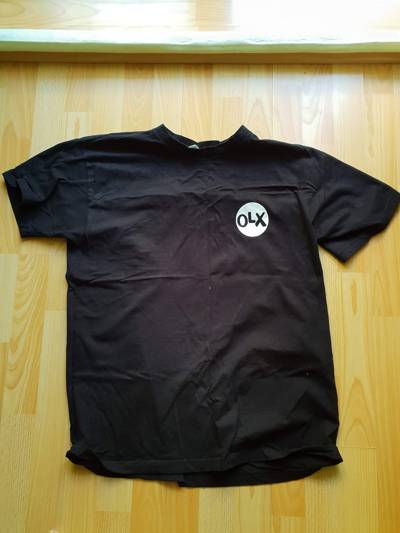

In [4]:
load_img(full_name)

In [5]:
# reduce target size for neural network
img = load_img(full_name, target_size=(299, 299))

In [6]:
# turn image into numpy array
x = np.array(img)
x.shape

(299, 299, 3)

## Pre-trained Convolutional Neural Network

* Use a network that was already trained on some data
* Imagenet dataset: https://image-net.org
* Pre-trained models: https://keras.io/api/applications
    * We will use the Xception model

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299,299,3))

* Use this model now to classify the image of the t-shirt above
* THis model does not expect a single image, but a couple of images

In [9]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

* Before applying the model we need to do some preprocessing

In [10]:
X = preprocess_input(X)

In [11]:
pred = model.predict(X)
pred.shape

(1, 1000)

* The output conatins the propabilty of the image of being in a specific class
* In total there are 1000 classes
* In order to understand the output, we need to now which are the classes
* For that we use the decode_predictions function, which gives the best results

In [12]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.679245),
  ('n02916936', 'bulletproof_vest', 0.03960029),
  ('n04370456', 'sweatshirt', 0.035299525),
  ('n03710637', 'maillot', 0.010884136),
  ('n04525038', 'velvet', 0.0018057585)]]

* Imagenet does not have a class "t-shirt"
* To predict the clothing classes we have, we need a different model for that
* We can use the Xceptions model and adjust it for our purpose
    * We don't have to train it from scratch

## Convolutional Neural Networks
* Mainly consists of convolutional and dense layers
    * A convolutional layer consists of filters (of simple shapes) and it is calculated how similar the pixels are to this filter.
    * These filters produce feature maps, which go to the next layer
    * In each layer the neural net can learn more complicated features
* After passing the image through the convolutional filters, we get a vector representation of the image
    * This vector representation is passed through a set of dense layers, which then give the prediction
    * The prediction is given as a propability
    * Depending on the problem, the last layer could be a 
        * Sigmoid layer for binary classification
        * a Softmax layer for multiple classification
* REcommended website: https://cs231n.github.io

## Transfer Learning
* Use a network that was trained on the imagente dataset
![transer_learning](Screenshot_1.png)


* We will use the convolutioal part of the network that converts the image into a vector representation.
* Read the data using ```ImageDataGenerator```
* Train ```Xception``` on smaller images (150 x 150)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# read images from directory
train_ds = train_gen.flow_from_directory('../data/clothing-dataset-small/train', 
                                         target_size=(150, 150), 
                                         batch_size=32)

Found 3068 images belonging to 10 classes.


* The input data size in (32, 150, 150, 3) [(batch_size, width, height, channels)]

In [15]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [16]:
# look at one image and target
X, y = next(train_ds)

In [17]:
X.shape

(32, 150, 150, 3)

In [18]:
y.shape

(32, 10)

In [19]:
y[:5] # multiclasss classification

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

* Now do the same for the validation dataset

In [20]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# read images from directory
val_ds = val_gen.flow_from_directory('../data/clothing-dataset-small/validation', 
                                         target_size=(150, 150), 
                                         batch_size=32,
                                         shuffle=False)

Found 341 images belonging to 10 classes.


![transfer_learning](Screenshot_2.png)

![nn in keras](Screenshot_3.png)

* Create the base model

In [21]:
base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(150, 150, 3))

base_model.trainable = False

* Create a new top

In [22]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs)

outputs = base

model = keras.Model(inputs, outputs)

In [23]:
preds = model.predict(X)

In [24]:
preds.shape

(32, 5, 5, 2048)

* Turn this output into a vector

![pooling](Screenshot_4.png)

In [25]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs)
pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

outputs = vectors

model = keras.Model(inputs, outputs)

In [26]:
preds = model.predict(X)

In [27]:
preds.shape

(32, 2048)

* Add the output layer

In [28]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [29]:
preds = model.predict(X)

In [30]:
preds.shape

(32, 10)

* This model still has to be trained!

In [31]:
learning_rate = 0.1
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [32]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [33]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 138s 1s/step - loss: 15.3939 - accuracy: 0.5389 - val_loss: 5.3118 - val_accuracy: 0.7185
Epoch 2/10
96/96 [==============================] - 140s 1s/step - loss: 4.5629 - accuracy: 0.7861 - val_loss: 6.3982 - val_accuracy: 0.7361
Epoch 3/10
96/96 [==============================] - 148s 2s/step - loss: 2.8703 - accuracy: 0.8440 - val_loss: 6.6066 - val_accuracy: 0.7918
Epoch 4/10
96/96 [==============================] - 141s 1s/step - loss: 2.5001 - accuracy: 0.8680 - val_loss: 8.5447 - val_accuracy: 0.7771
Epoch 5/10
96/96 [==============================] - 109s 1s/step - loss: 2.4014 - accuracy: 0.8815 - val_loss: 7.5385 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 119s 1s/step - loss: 1.8285 - accuracy: 0.9050 - val_loss: 8.2347 - val_accuracy: 0.7918
Epoch 7/10
96/96 [==============================] - 114s 1s/step - loss: 1.5143 - accuracy: 0.9106 - val_loss: 8.9110 - val_accuracy: 0.8123
Epoch 8/10
9

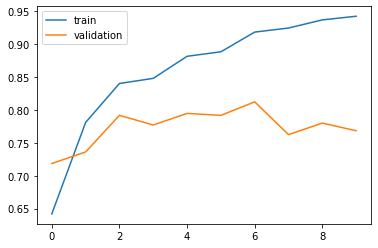

In [34]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="validation")
plt.legend();

## Adjusting the Learning Rate
* Too high learning rate may leas to overfitting, too low learning rate may take very long



In [35]:
def make_model(learning_rate=.1):
    base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(150, 150, 3))

    base_model.trainable = False
    
    ##############################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    ##############################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [36]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

0.0001
Epoch 1/10
96/96 [==============================] - 110s 1s/step - loss: 2.1608 - accuracy: 0.2484 - val_loss: 1.5446 - val_accuracy: 0.5132
Epoch 2/10
96/96 [==============================] - 120s 1s/step - loss: 1.4526 - accuracy: 0.5399 - val_loss: 1.1996 - val_accuracy: 0.6246
Epoch 3/10
96/96 [==============================] - 105s 1s/step - loss: 1.1589 - accuracy: 0.6444 - val_loss: 1.0249 - val_accuracy: 0.7038
Epoch 4/10
96/96 [==============================] - 148s 2s/step - loss: 0.9971 - accuracy: 0.6867 - val_loss: 0.9208 - val_accuracy: 0.7331
Epoch 5/10
96/96 [==============================] - 155s 2s/step - loss: 0.8982 - accuracy: 0.7220 - val_loss: 0.8507 - val_accuracy: 0.7507
Epoch 6/10
96/96 [==============================] - 148s 2s/step - loss: 0.8465 - accuracy: 0.7307 - val_loss: 0.8041 - val_accuracy: 0.7654
Epoch 7/10
96/96 [==============================] - 149s 2s/step - loss: 0.7852 - accuracy: 0.7489 - val_loss: 0.7607 - val_accuracy: 0.7683
Epoch 

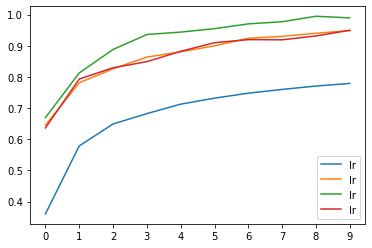

In [37]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label="lr")
    plt.xticks(np.arange(10))
plt.legend();

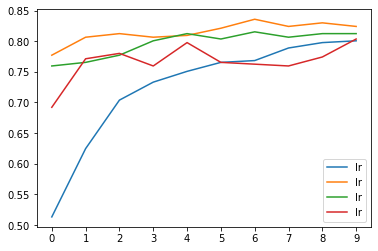

In [38]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label="lr")
    plt.xticks(np.arange(10))
plt.legend();

* Choose the ```learning_rate=0.001```

## Checkpointing

* Maybe the last results are not he best ones. Too have the best results we save models during training, when results are better than the previous model
* After each epoch ```Calllbacks``` can be invoked

In [39]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')

In [40]:
learning_rate = 0.001

model = make_model(learning_rate)
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/10
96/96 [==============================] - 132s 1s/step - loss: 1.4994 - accuracy: 0.4937 - val_loss: 0.7027 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 131s 1s/step - loss: 0.6552 - accuracy: 0.7815 - val_loss: 0.6149 - val_accuracy: 0.8094
Epoch 3/10
96/96 [==============================] - 132s 1s/step - loss: 0.4939 - accuracy: 0.8409 - val_loss: 0.5807 - val_accuracy: 0.7977
Epoch 4/10
96/96 [==============================] - 131s 1s/step - loss: 0.4225 - accuracy: 0.8661 - val_loss: 0.5623 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 134s 1s/step - loss: 0.3721 - accuracy: 0.8992 - val_loss: 0.5416 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 155s 2s/step - loss: 0.3120 - accuracy: 0.9062 - val_loss: 0.5359 - val_accuracy: 0.8065
Epoch 7/10
96/96 [==============================] - 151s 2s/step - loss: 0.2969 - accuracy: 0.9153 - val_loss: 0.5312 - val_accuracy: 0.8240
Epoch 8/10
96

## Adding more Layers

* Add another dense layer, this needs an activation function. Here we use ```ReLU``` activation
* To see how much the GPU is used, use ```nvidia-smi``` in the terminal
    * e.g. ```watch nvidia-smi``` during training

In [41]:
def make_model(learning_rate=.1, size_inner=100):
    base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(150, 150, 3))

    base_model.trainable = False
    
    ##############################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)

    ##############################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [42]:
learning_rate = 0.001
scores = {}

for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

10
Epoch 1/10
96/96 [==============================] - 127s 1s/step - loss: 1.7759 - accuracy: 0.4114 - val_loss: 1.1747 - val_accuracy: 0.6686
Epoch 2/10
96/96 [==============================] - 125s 1s/step - loss: 1.0111 - accuracy: 0.6946 - val_loss: 0.8919 - val_accuracy: 0.7361
Epoch 3/10
96/96 [==============================] - 132s 1s/step - loss: 0.7266 - accuracy: 0.7677 - val_loss: 0.7750 - val_accuracy: 0.7801
Epoch 4/10
96/96 [==============================] - 131s 1s/step - loss: 0.6432 - accuracy: 0.7912 - val_loss: 0.7512 - val_accuracy: 0.7654
Epoch 5/10
96/96 [==============================] - 132s 1s/step - loss: 0.5288 - accuracy: 0.8272 - val_loss: 0.6926 - val_accuracy: 0.7977
Epoch 6/10
96/96 [==============================] - 131s 1s/step - loss: 0.4632 - accuracy: 0.8631 - val_loss: 0.6664 - val_accuracy: 0.7859
Epoch 7/10
96/96 [==============================] - 130s 1s/step - loss: 0.4324 - accuracy: 0.8651 - val_loss: 0.6388 - val_accuracy: 0.7918
Epoch 8/10

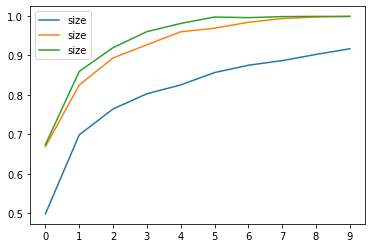

In [43]:
for size, hist in scores.items():
    plt.plot(hist['accuracy'], label="size")
    plt.xticks(np.arange(10))
plt.legend();

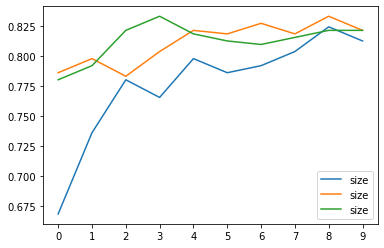

In [44]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label="size")
    plt.xticks(np.arange(10))
plt.legend();

## Regularization and Dropout
* Regularization by freezing a part of the network
* Adding Dropout to our model
* Experimenting with different values

![regularization](Screenshot_5.png)
![regularization](Screenshot_6.png)

In [45]:
def make_model(learning_rate=.1, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(150, 150, 3))

    base_model.trainable = False
    
    ##############################
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    ##############################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

![sketch model](Screenshot_7.png)

In [46]:
learning_rate = 0.001
size = 100
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[lr] = history.history

0.0
Epoch 1/30
96/96 [==============================] - 108s 1s/step - loss: 1.2499 - accuracy: 0.5813 - val_loss: 0.6282 - val_accuracy: 0.7859
Epoch 2/30
96/96 [==============================] - 107s 1s/step - loss: 0.5024 - accuracy: 0.8375 - val_loss: 0.5531 - val_accuracy: 0.8065
Epoch 3/30
96/96 [==============================] - 107s 1s/step - loss: 0.3602 - accuracy: 0.8820 - val_loss: 0.5879 - val_accuracy: 0.8006
Epoch 4/30
96/96 [==============================] - 100s 1s/step - loss: 0.2516 - accuracy: 0.9263 - val_loss: 0.5473 - val_accuracy: 0.8211
Epoch 5/30
96/96 [==============================] - 98s 1s/step - loss: 0.1592 - accuracy: 0.9579 - val_loss: 0.5380 - val_accuracy: 0.8328
Epoch 6/30
96/96 [==============================] - 97s 1s/step - loss: 0.1261 - accuracy: 0.9710 - val_loss: 0.5605 - val_accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 98s 1s/step - loss: 0.0867 - accuracy: 0.9822 - val_loss: 0.5499 - val_accuracy: 0.8211
Epoch 8/30
9

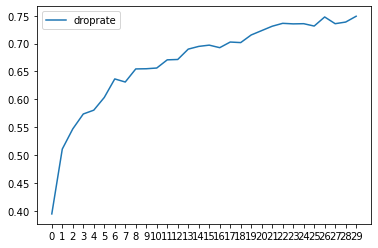

In [47]:
for droprate, hist in scores.items():
    plt.plot(hist['accuracy'], label="droprate")
    plt.xticks(np.arange(30))
plt.legend();

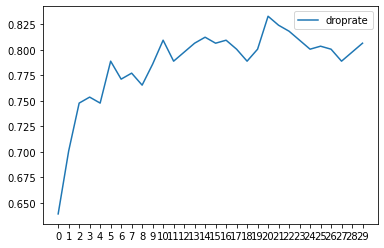

In [48]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label="droprate")
    plt.xticks(np.arange(30))
plt.legend();

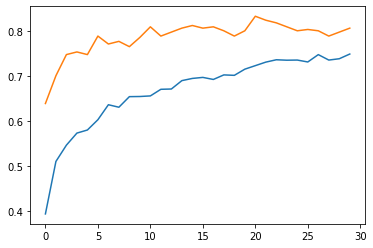

In [52]:
# look at specific droprates for training and validation
hist = scores[0.1]
plt.plot(hist['accuracy'], label="droprate")
plt.plot(hist['val_accuracy'], label="droprate");

## Data Augmentation

* Create more data from the existing data
* Possible image transformations
    * flip (horiontally, vertically)
    * rotation
    * shift, width-shift
    * shear 
    * zoom
    * brightness/ contrast
    * black patch
* All these transformations can be combined
* In keras this can be done in the ```ImageDataGenerator```
* Augmentation is only applied to the training dataset, not to the validation set

In [53]:
train_gen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                shear_range=10.0,
                zoom_range=0.1,
                vertical_flip=True
                )

# read images from directory
train_ds = train_gen.flow_from_directory('../data/clothing-dataset-small/train', 
                                         target_size=(150, 150), 
                                         batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# read images from directory
val_ds = val_gen.flow_from_directory('../data/clothing-dataset-small/validation', 
                                         target_size=(150, 150), 
                                         batch_size=32)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


### How to choose augmentation:

* Use your own judgement (Does it make sense?)
* Look at the images, what kind of variations are there?
    * E.g. are objects always centeres?
* Tune as a hyperparameter
    * Train for a certain amount of epochs -> Is it better?

In [54]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 112s 1s/step - loss: 1.6114 - accuracy: 0.4490 - val_loss: 0.8044 - val_accuracy: 0.7331
Epoch 2/10
96/96 [==============================] - 143s 1s/step - loss: 0.9001 - accuracy: 0.7079 - val_loss: 0.6676 - val_accuracy: 0.7947
Epoch 3/10
96/96 [==============================] - 123s 1s/step - loss: 0.8034 - accuracy: 0.7246 - val_loss: 0.6446 - val_accuracy: 0.7801
Epoch 4/10
96/96 [==============================] - 113s 1s/step - loss: 0.7502 - accuracy: 0.7343 - val_loss: 0.6332 - val_accuracy: 0.7947
Epoch 5/10
96/96 [==============================] - 112s 1s/step - loss: 0.6272 - accuracy: 0.7828 - val_loss: 0.5863 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 112s 1s/step - loss: 0.6340 - accuracy: 0.7740 - val_loss: 0.5930 - val_accuracy: 0.8211
Epoch 7/10
96/96 [==============================] - 110s 1s/step - loss: 0.5851 - accuracy: 0.7980 - val_loss: 0.5900 - val_accuracy: 0.7918
Epoch 8/10
96

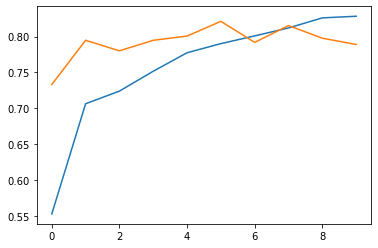

In [60]:
hist = history
plt.plot(hist.history['accuracy'], label="train")
plt.plot(hist.history['val_accuracy'], label="valid");

## Train a larger Model
* train on images 299x299 

In [61]:
def make_model(input_size=150, 
               learning_rate=.1, 
               size_inner=100, 
               droprate=0.5):
    base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(input_size, input_size, 3))

    base_model.trainable = False
    
    ##############################
    
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    ##############################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [62]:
train_gen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                shear_range=10.0,
                zoom_range=0.1,
                vertical_flip=True
                )

# read images from directory
train_ds = train_gen.flow_from_directory('../data/clothing-dataset-small/train', 
                                         target_size=(299, 299), 
                                         batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# read images from directory
val_ds = val_gen.flow_from_directory('../data/clothing-dataset-small/validation', 
                                         target_size=(299, 299), 
                                         batch_size=32)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [63]:
checkpoint = keras.callbacks.ModelCheckpoint(
                    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
                    save_best_only=True,
                    monitor='val_accuracy',
                    mode='max')

In [64]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size = 299

model = make_model(
        input_size=input_size,
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate)

history = model.fit(train_ds, 
                    epochs=5, 
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/5
96/96 [==============================] - 447s 5s/step - loss: 1.4414 - accuracy: 0.5220 - val_loss: 0.5670 - val_accuracy: 0.8152
Epoch 2/5
96/96 [==============================] - 423s 4s/step - loss: 0.7087 - accuracy: 0.7538 - val_loss: 0.4926 - val_accuracy: 0.8152
Epoch 3/5
96/96 [==============================] - 402s 4s/step - loss: 0.5693 - accuracy: 0.8063 - val_loss: 0.4612 - val_accuracy: 0.8211
Epoch 4/5
96/96 [==============================] - 420s 4s/step - loss: 0.4935 - accuracy: 0.8339 - val_loss: 0.4405 - val_accuracy: 0.8534
Epoch 5/5
96/96 [==============================] - 445s 5s/step - loss: 0.4677 - accuracy: 0.8431 - val_loss: 0.4391 - val_accuracy: 0.8475


## Using the Model

* Loading the Model
* Evaluating the Model
* Getting Predictions

**Pretend the model has been trained and we now start a new Notebook**

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np

In [66]:
model = keras.models.load_model('xception_v4_05_0.850.h5')

In [67]:
# read test dataset in the same way as validation dataset
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# read images from directory
test_ds = test_gen.flow_from_directory('../data/clothing-dataset-small/validation', 
                                         target_size=(299, 299), 
                                         batch_size=32,
                                         shuffle=False)

Found 341 images belonging to 10 classes.


In [62]:
# gives loss and accuracy on test set
model.evaluate(test_ds)

11/11 [==============================] - 35s 3s/step - loss: 0.4433 - accuracy: 0.8504


[0.443279892206192, 0.8504399061203003]

In [66]:
# apply the model to an image
path = '../data/clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

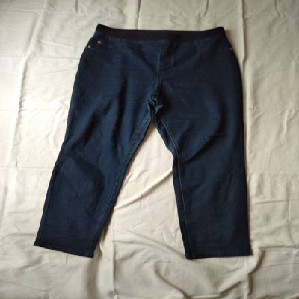

In [67]:
img = load_img(path, target_size=(299,299))
img

In [68]:
# turn image into a numpy array
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [70]:
X = preprocess_input(X)

In [71]:
pred = model.predict(X)

In [72]:
pred[0]

array([-1.7340311 , -3.5461495 ,  0.06269813,  1.0456045 ,  8.627468  ,
       -0.29695672, -4.8185697 ,  3.4118295 , -0.6146142 , -1.990872  ],
      dtype=float32)

In [73]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [74]:
dict(zip(classes, pred[0]))

{'dress': -1.7340311,
 'hat': -3.5461495,
 'longsleeve': 0.062698126,
 'outwear': 1.0456045,
 'pants': 8.627468,
 'shirt': -0.29695672,
 'shoes': -4.8185697,
 'shorts': 3.4118295,
 'skirt': -0.6146142,
 't-shirt': -1.990872}

**Note**

The predictions here are not propabilities, but logits
* could be transformed into propabilities (using softmax), but can also be treated as relative likelihoods. I.e. the largest number is the predicted class 

## Summary
* We can use transfer-learning for general image classification
* Convolutional layers let us turn images into a vector
* Dense layers use the vector to make predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150), before training a big one (299x299)
* Learning rate - how fast the model trains. Fast learners aren't always the best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation